In [1]:
import math 
import astropy.io.fits as fits
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA
from mpl_toolkits.axes_grid1 import make_axes_locatable
from icasso import Icasso


In [2]:
#cut so just primary beam
def primary_beam(data):
    idx0 = 2048//2 - 1024//2

    idx1 = 2048//2 + 1024//2
    pixel_size = idx1 -idx0


    return data[idx0:idx1, idx0:idx1,:]

In [3]:
def pearson_correl(x,y):
 return (np.sum((x-np.mean(x))*(y-np.mean(y))))/(np.sqrt(np.sum((x-np.mean(x))**2)*np.sum((y-np.mean(y))**2)))

In [4]:
def bootstrap_fun(data, generator):
    return data[generator.choice(range(data.shape[0]), size=data.shape[0]), :]

def unmixing_fun(ica):
    return ica.components_

In [5]:
def do_fastica(data, comps, shape):
    f_ica = FastICA(n_components=comps)
    #generate the 4 componets
    S = f_ica.fit_transform(data.reshape((shape[0]*shape[1],shape[2])))
    
    #get mixing matrix
    A = f_ica.mixing_
    
    #make model
    model_fICA = (np.matmul(A,S.T).T).reshape((shape[0],shape[1],shape[2]))
    
    #get resids
    resids_fICA = data - model_fICA #residuals 
    
    return model_fICA, resids_fICA, S, A

In [7]:
idx0 = 2048//2 - 1024//2
idx1 = 2048//2 + 1024//2
with fits.open('/home/ppxjf3/SKAO_DATA_CHALLENGE/bss_v1/vis_sub_allfreqs.fits', memmap=True) as hdu:
    subtract_img =np.array(hdu[0].data[idx0:idx1,idx0:idx1,600:675]) #10MHz centered on 166MHz
    hdu.info()
    print(subtract_img.shape)

Filename: /home/ppxjf3/SKAO_DATA_CHALLENGE/bss_v1/vis_sub_allfreqs.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       7   (901, 2048, 2048)   float64   
(1024, 1024, 75)


In [8]:
random_state = 10
distance = 0.5
data = subtract_img
shape = data.shape
print(shape)
data_reshape = data.reshape((shape[0]*shape[1],shape[2]))

(1024, 1024, 75)


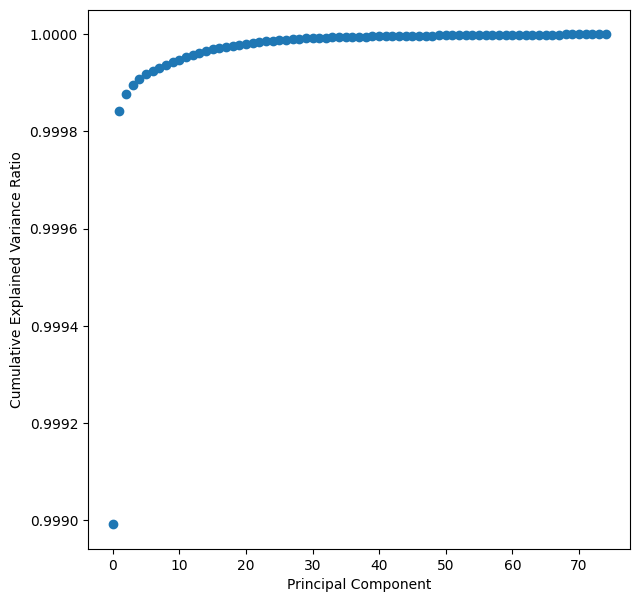

In [10]:
from sklearn.decomposition import PCA

# how many components explain a % of variance
pca = PCA()
pca.fit(data_reshape)

plt.figure(figsize=(7, 7))
plt.scatter(
    x=np.arange(pca.n_components_), y=np.cumsum(pca.explained_variance_ratio_)
)
plt.xlabel("Principal Component")
plt.ylabel("Cumulative Explained Variance Ratio")
plt.show()

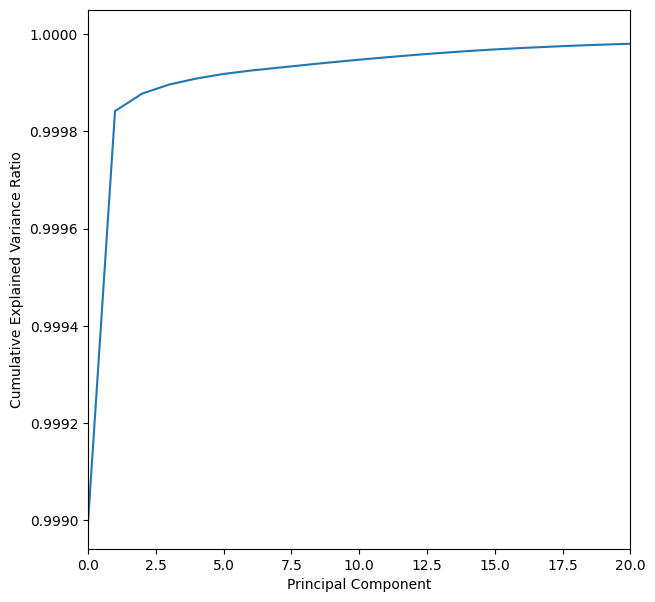

In [11]:
plt.figure(figsize=(7, 7))
plt.plot(
    np.arange(pca.n_components_), np.cumsum(pca.explained_variance_ratio_)
)
plt.xlabel("Principal Component")
plt.ylabel("Cumulative Explained Variance Ratio")
plt.xlim((0,20))
plt.show()

initialise the ICASSO method with an inital component guess and the number of time to itterate over 

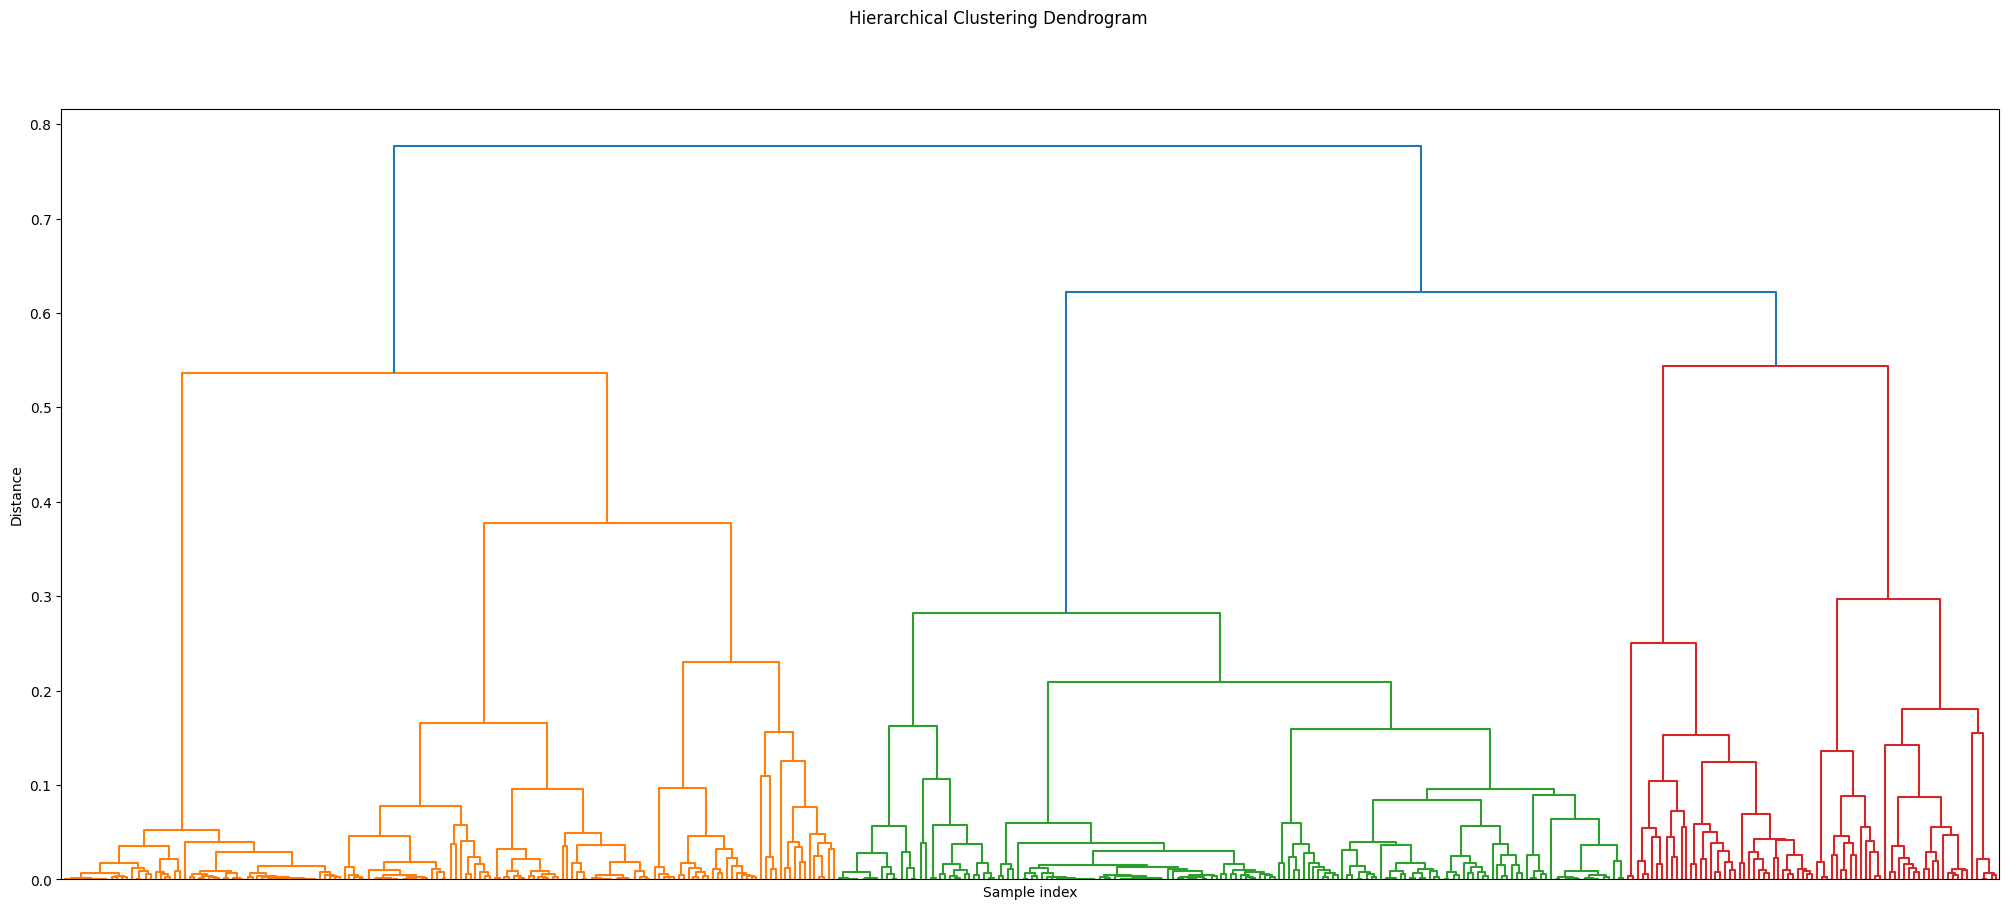

/home/ppxjf3/miniconda3/lib/python3.10/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


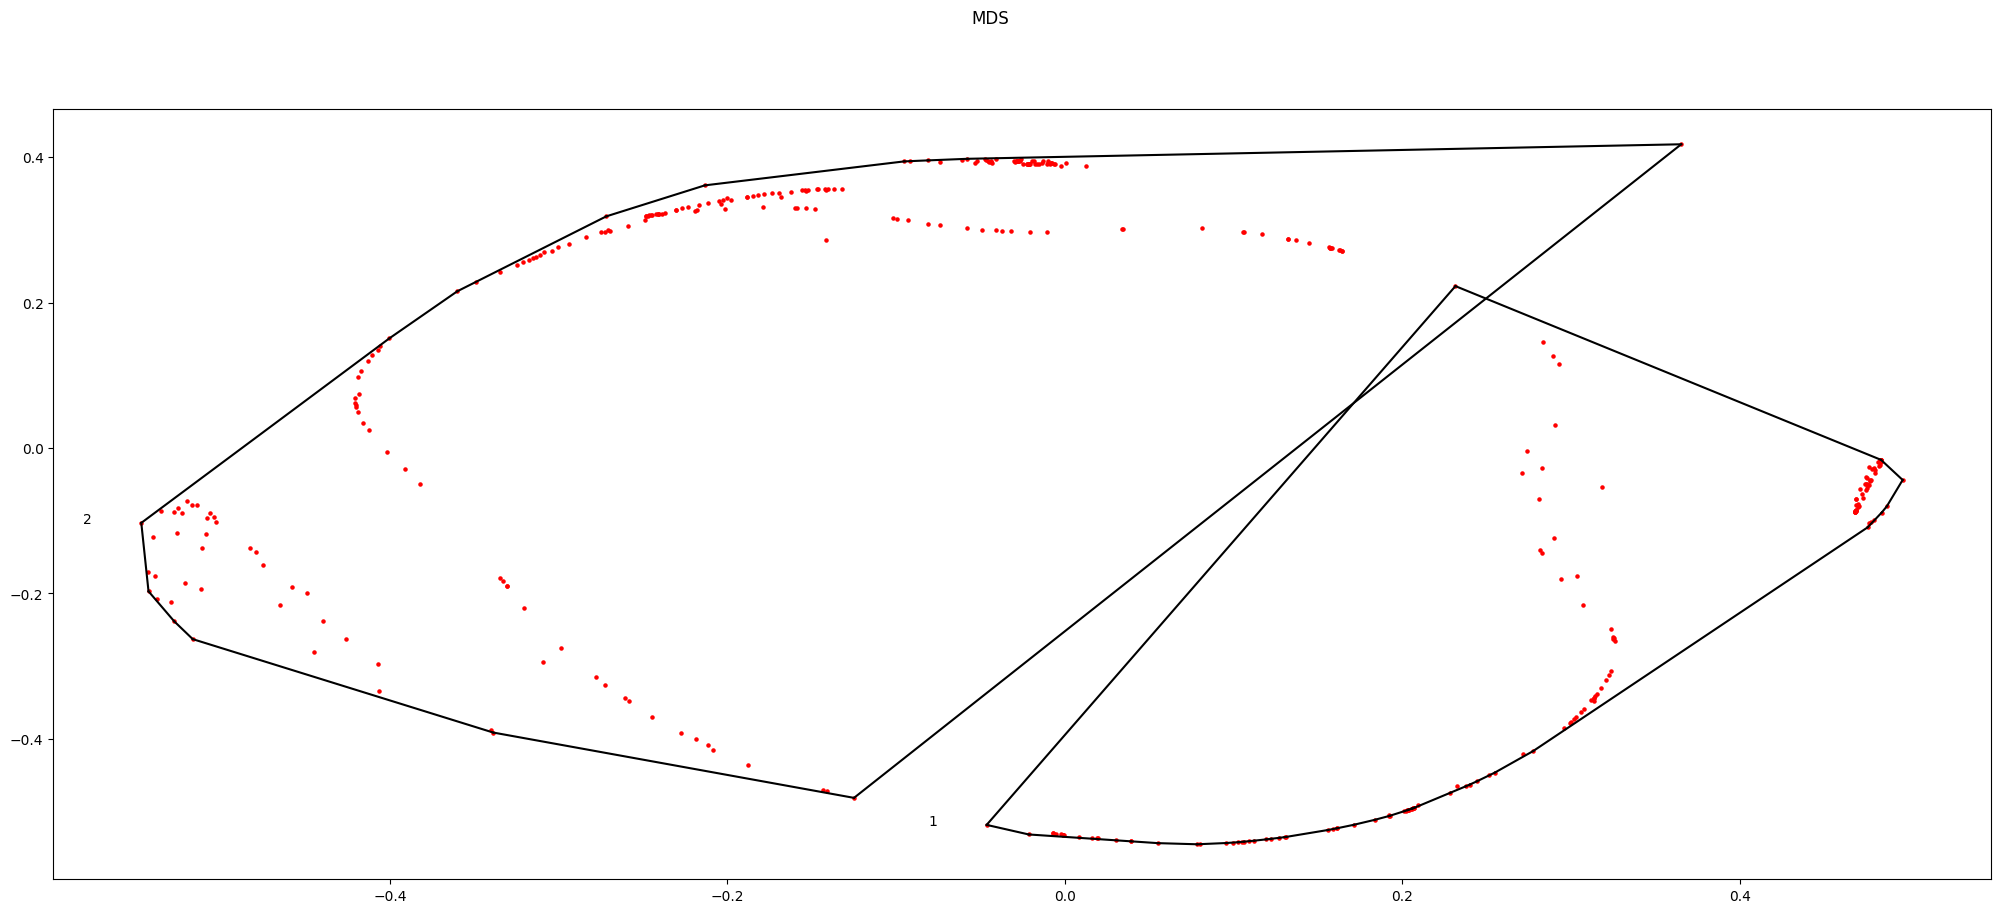

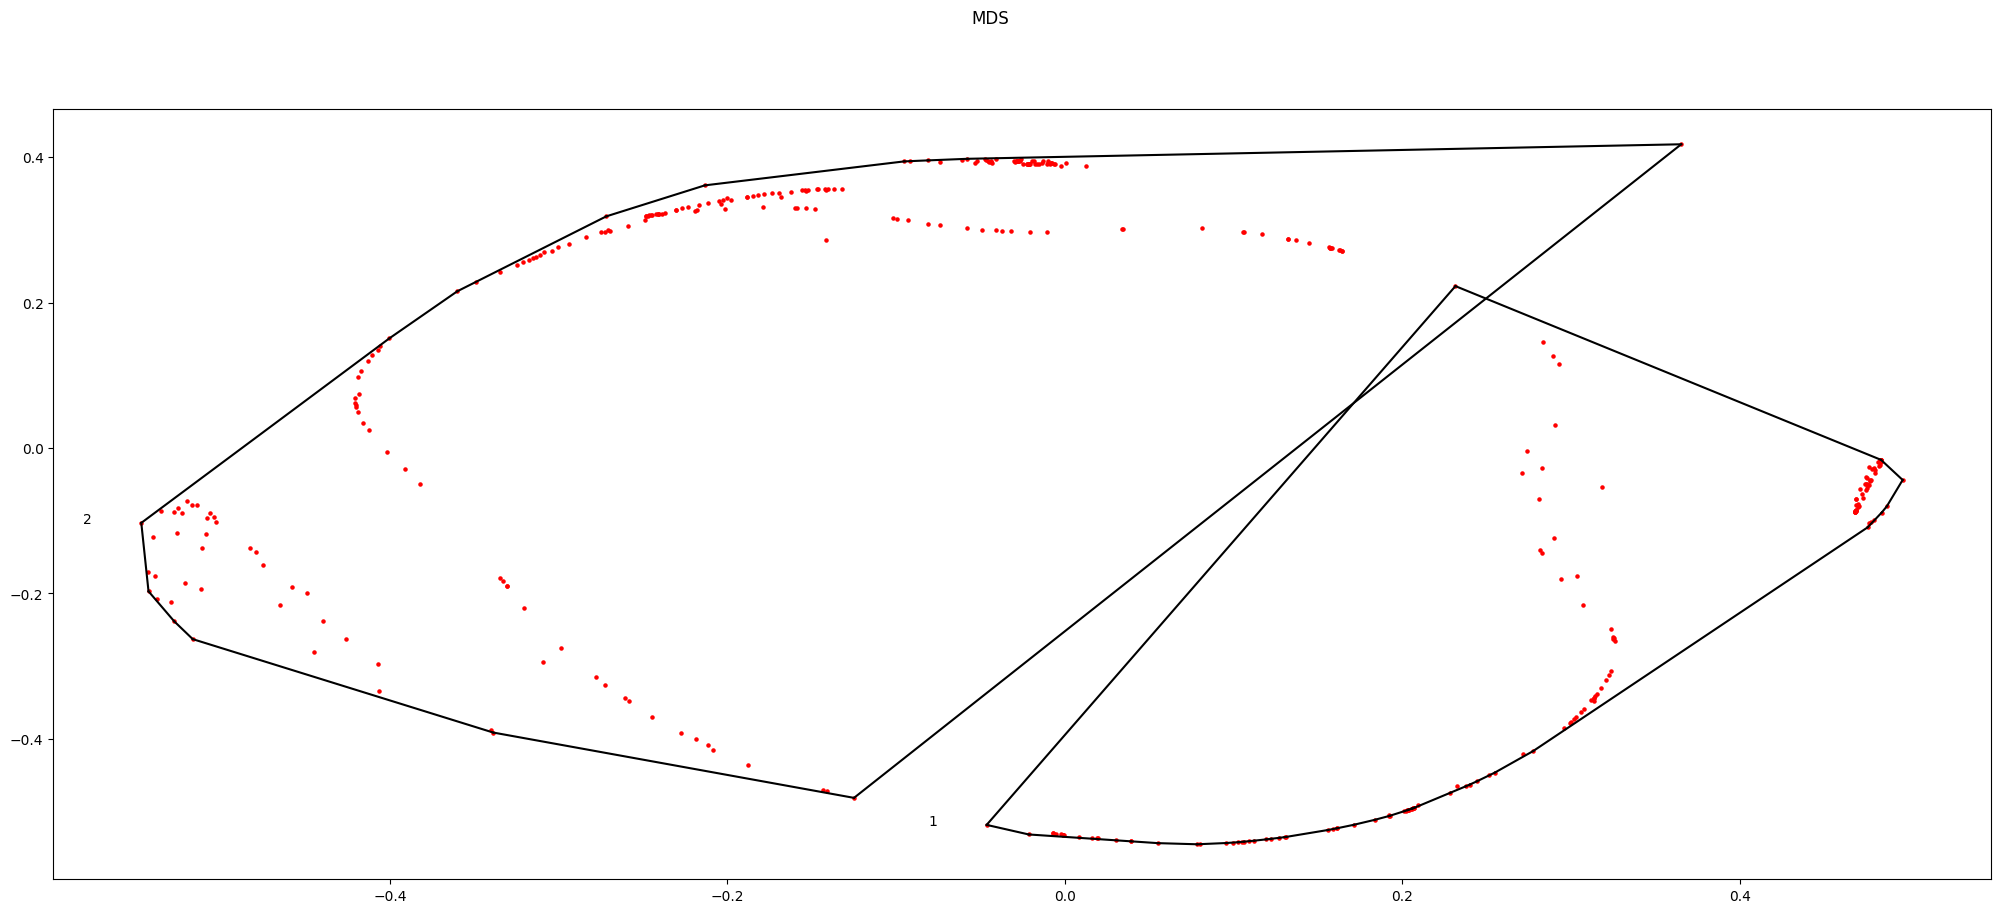

In [12]:
ica_params = {'n_components': 4} 
icasso4 = Icasso(FastICA, ica_params=ica_params, iterations=100, bootstrap=False,
                vary_init=True)


icasso4.fit(data=data_reshape, fit_params={}, random_state=random_state,
           bootstrap_fun=bootstrap_fun, unmixing_fun=unmixing_fun)

icasso4.plot_dendrogram()

icasso4.plot_mds(distance=0.7)

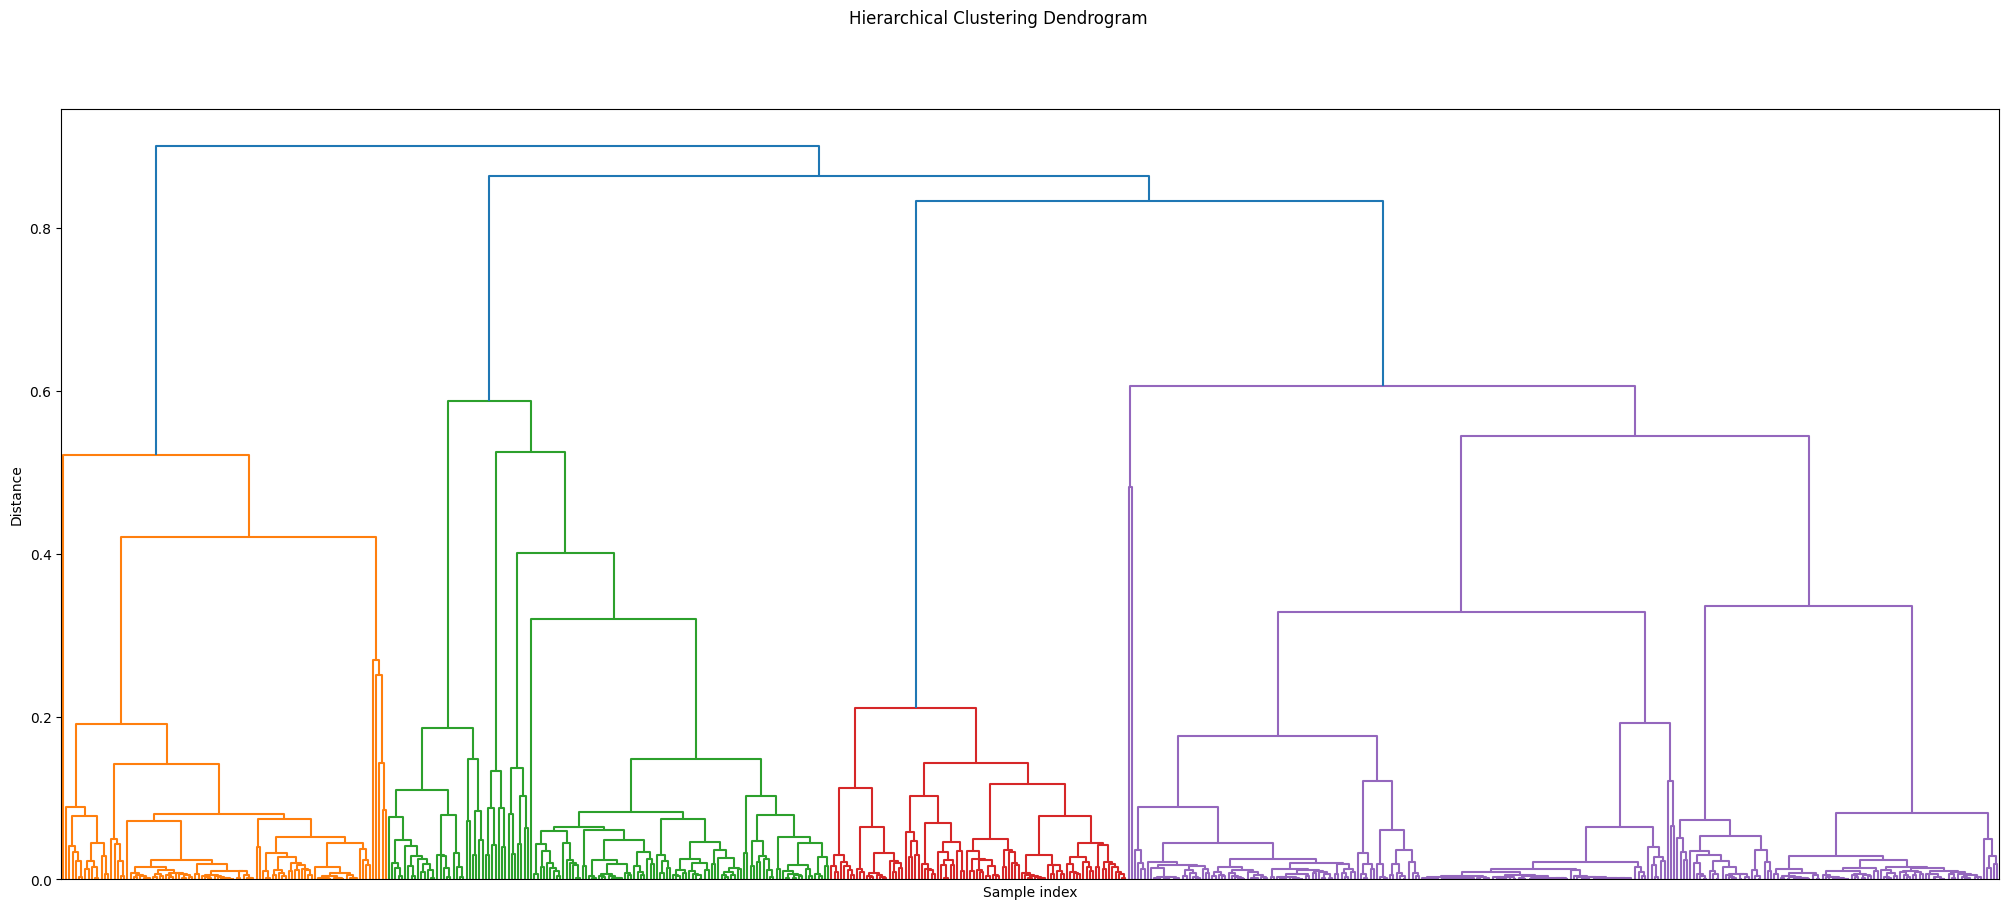

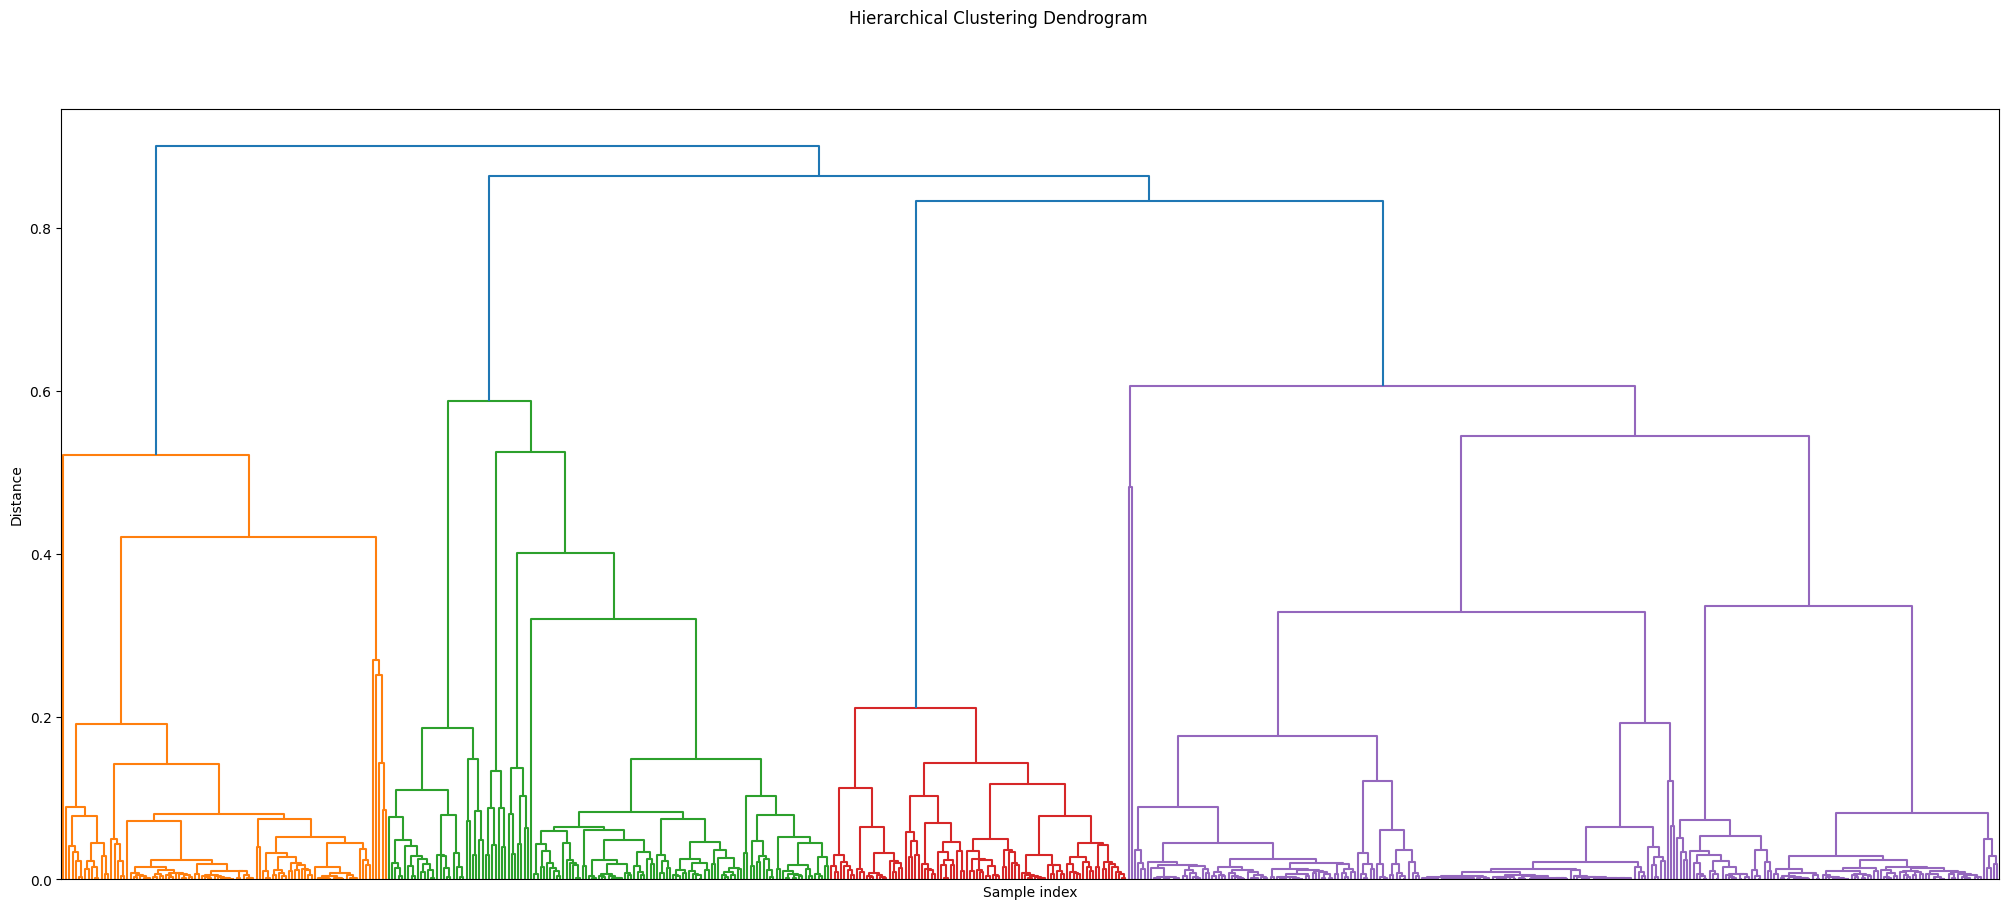

In [13]:
ica_params = {'n_components': 6} 
icasso6 = Icasso(FastICA, ica_params=ica_params, iterations=100, bootstrap=False,
                vary_init=True)


icasso6.fit(data=data_reshape, fit_params={}, random_state=random_state,
           bootstrap_fun=bootstrap_fun, unmixing_fun=unmixing_fun)

icasso6.plot_dendrogram()

Dendrogram shows how well connected each component found for all the itterations is, it also shows distance on the y axis which can be used to set a threshold later to get the mixing matrix for a set number of components

ica_params = {'n_components': 6} 
icasso = Icasso(FastICA, ica_params=ica_params, iterations=10, bootstrap=False,
                vary_init=True)


icasso.fit(data=data_reshape, fit_params={}, random_state=random_state,
           bootstrap_fun=bootstrap_fun, unmixing_fun=unmixing_fun)

icasso.plot_dendrogram()

The distance in the MDS plot sets the threshold at which the components are clustered together, in a 2D space, could use this clustering to pick a component number?

/home/ppxjf3/miniconda3/lib/python3.10/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


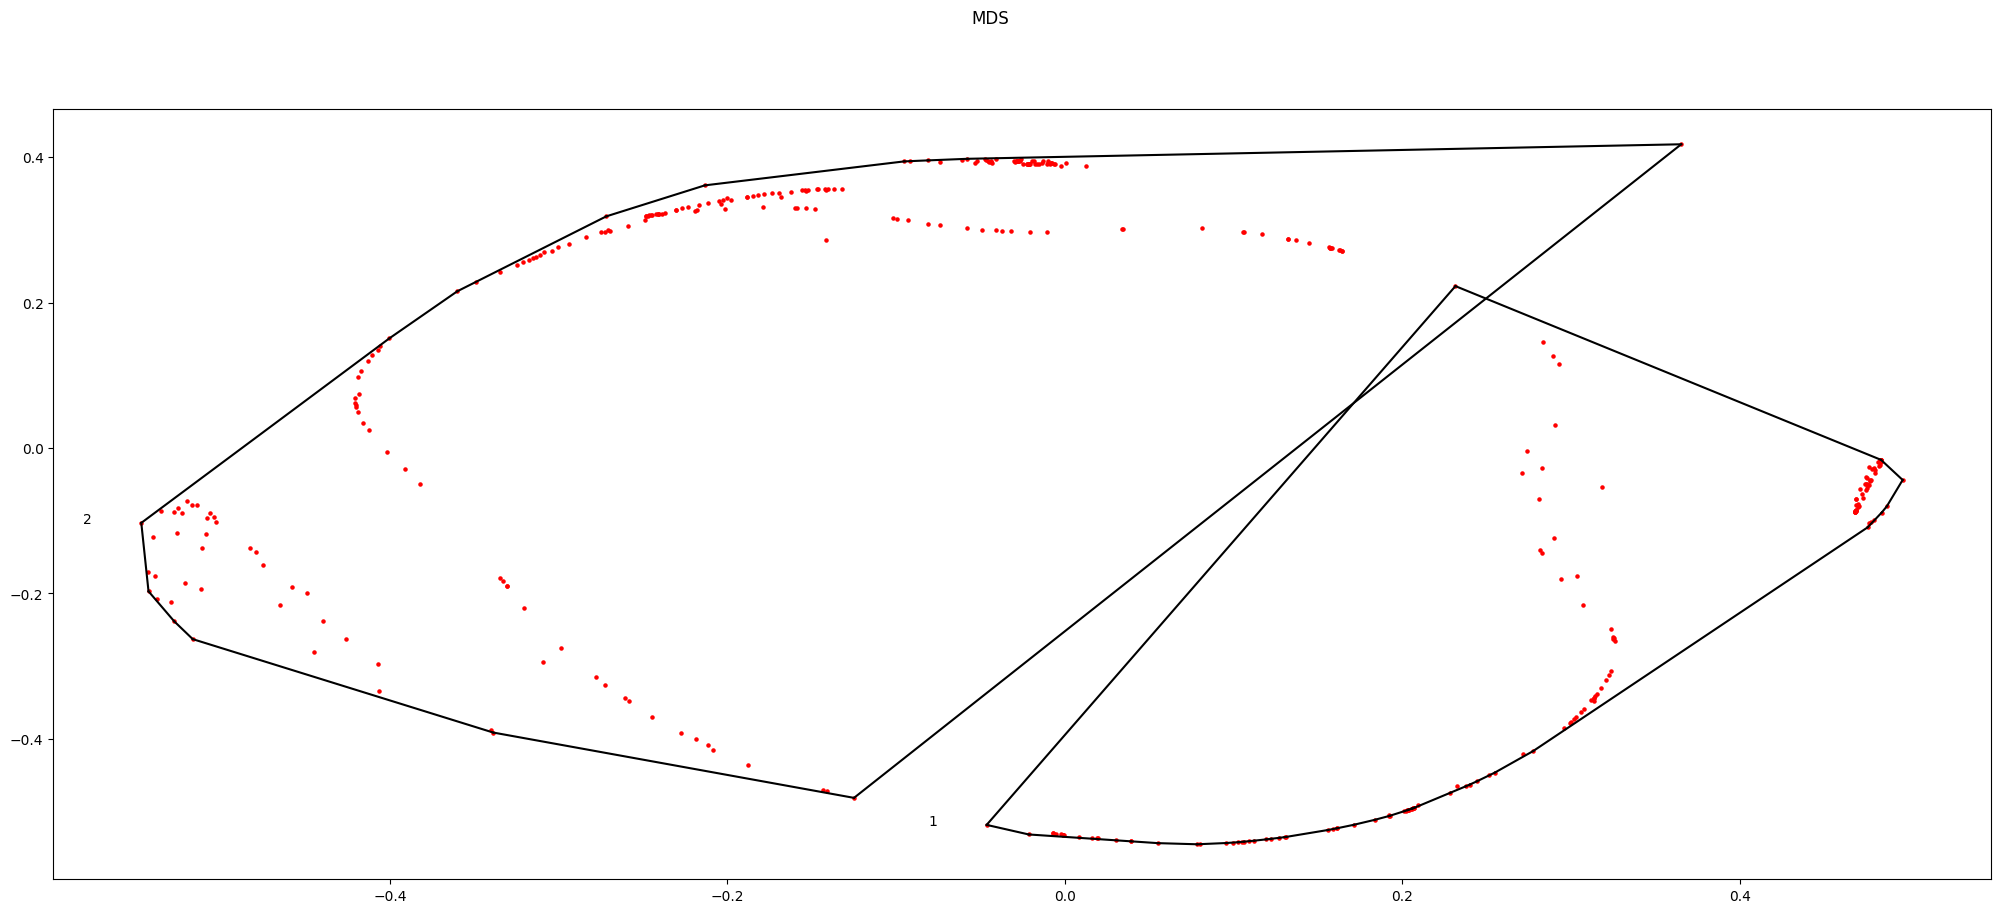

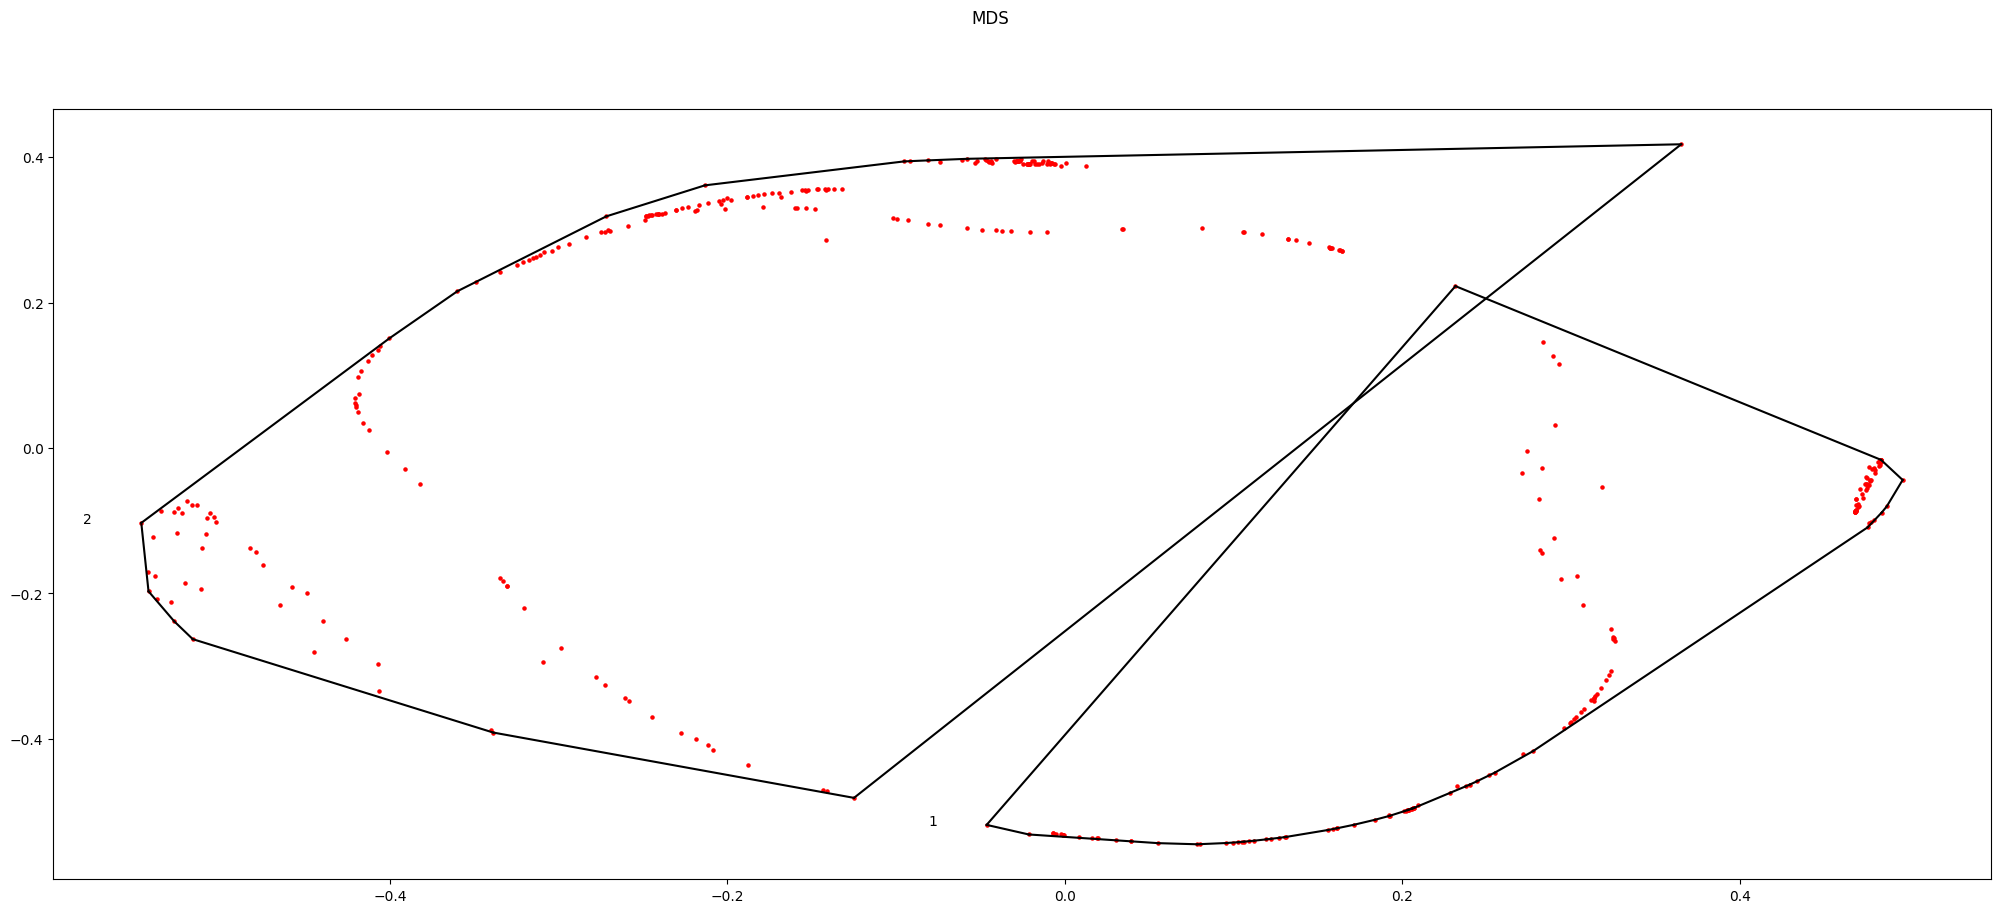

In [14]:
icasso4.plot_mds(distance=0.7)

Get the unmixing matrix for the number of ICs set by the threshold and correlation coefficient between each 1st, 2nd, 3rd etc IC to determine it's 'Quality'

In [16]:
data = data.reshape((shape[0]*shape[1],shape[2]))
W_6, scores6 , A6, S6 = icasso6.get_centrotype_unmixing(distance=0.5)
S_6 = np.dot(W_6, data.T).T #ICs

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (9,) + inhomogeneous part.

In [17]:
W_4, scores4, A4, S4 = icasso4.get_centrotype_unmixing(distance=0.5)
print(W_.shape)
print(A.shape)
print(data_reshape.shape)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (5,) + inhomogeneous part.

In [ ]:
S_4 = np.dot(W_4, data_reshape.T) #ICs
print(S_.shape)

Check against 

In [81]:
s1 = S_4[0,:].reshape(1024,1024)
s2 = S_4[1,:].reshape(1024,1024)
s3 = S_4[2,:].reshape(1024,1024)
s4 = S_4[3,:].reshape(1024,1024)

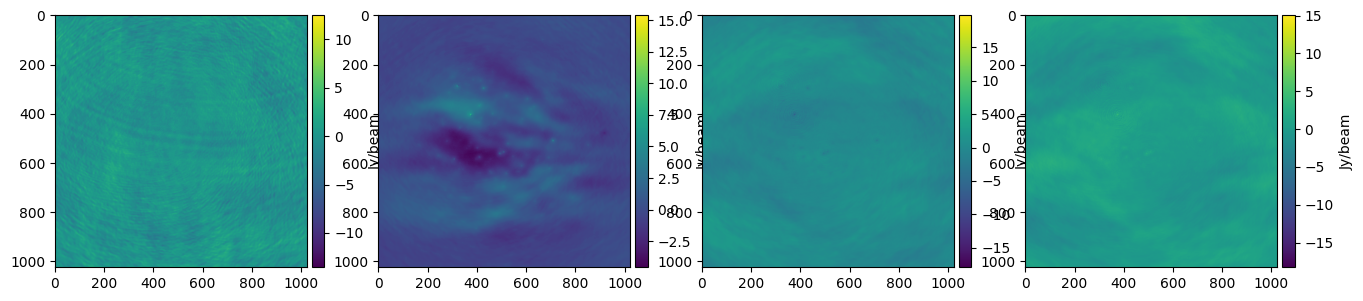

In [91]:
fig = plt.figure(figsize=(16, 12))
ax1 = fig.add_subplot(141)
im1 = ax1.imshow(s1[:,:])
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical', label='Jy/beam')

ax2 = fig.add_subplot(142)
im2 = ax2.imshow(s2[:,:])
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical', label='Jy/beam')

ax3 = fig.add_subplot(143)
im3 = ax3.imshow(s3[:,:])
divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im3, cax=cax, orientation='vertical', label='Jy/beam')

ax4 = fig.add_subplot(144)
im4 = ax4.imshow(s4[:,:])
divider = make_axes_locatable(ax4)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im4, cax=cax, orientation='vertical', label='Jy/beam')


In [84]:
model_fICA, resids_fICA, S, A = do_fastica(data, 4, data.shape)

In [88]:
s1_ = S[:,0].reshape(1024,1024)
s2_ = S[:,1].reshape(1024,1024)
s3_ = S[:,2].reshape(1024,1024)
s4_ = S[:,3].reshape(1024,1024)

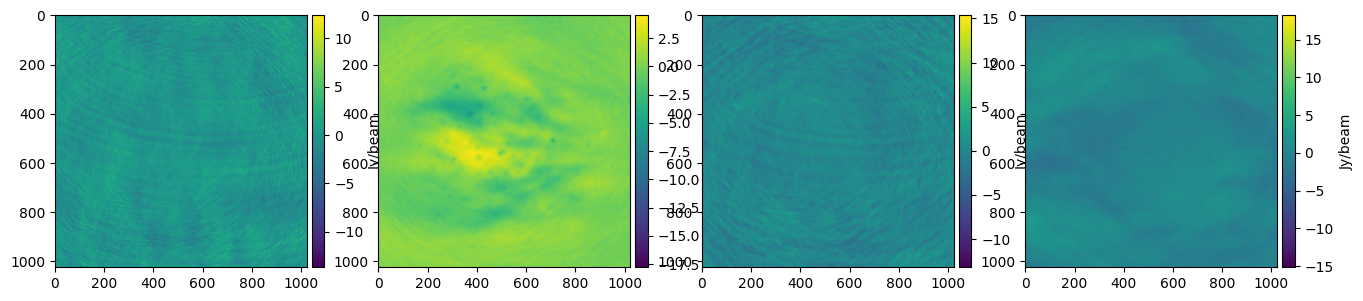

In [92]:
fig = plt.figure(figsize=(16, 12))
ax1 = fig.add_subplot(141)
im1 = ax1.imshow(s1_[:,:])
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical', label='Jy/beam')

ax2 = fig.add_subplot(142)
im2 = ax2.imshow(s2_[:,:])
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical', label='Jy/beam')

ax3 = fig.add_subplot(143)
im3 = ax3.imshow(s3_[:,:])
divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im3, cax=cax, orientation='vertical', label='Jy/beam')

ax4 = fig.add_subplot(144)
im4 = ax4.imshow(s4_[:,:])
divider = make_axes_locatable(ax4)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im4, cax=cax, orientation='vertical', label='Jy/beam')


In [25]:
model = (np.matmul(A,S_))

In [26]:
model = model.reshape(75,1024,1024)

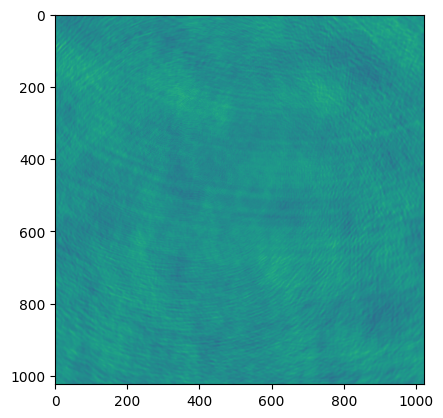

In [27]:
plt.imshow(model[33,:,:])

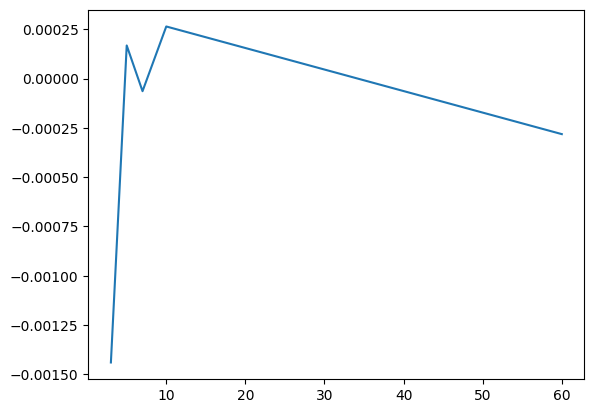

In [30]:
dist = np.arange(0,1,0.2)
correl = np.empty([len(dist)])
comp = np.empty([len(dist)])
data_reshape2 = data.reshape(data.shape[0]*data.shape[1]*data.shape[2])
for i in range(0,len(dist)):
    #make model
    W_, scores, A, S = icasso.get_centrotype_unmixing(distance=dist[i])
    S_ = np.dot(W_, data_reshape.T) #ICs
    model = (np.matmul(A,S_))
    model = model.reshape(75*1024*1024)
    correl[i] = pearson_correl(model,data_reshape2)
    comp[i] = len(S_)

plt.plot(comp,correl) 
plt.show()


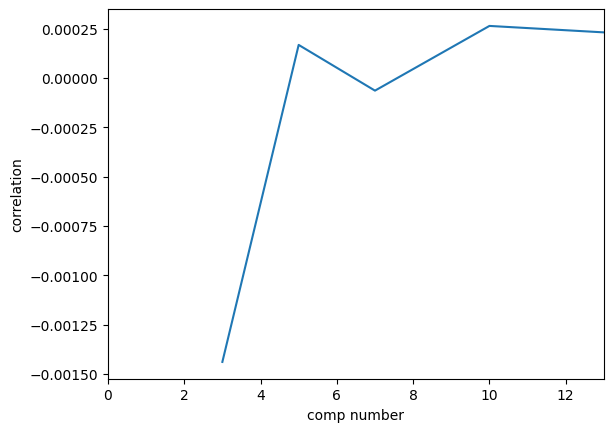

In [37]:
plt.plot(comp,correl) 
plt.ylabel('correlation')
plt.xlim((0, 13))   #
plt.xlabel('comp number')
plt.show()

Quality Index, i.e how well correlated are all the ith components found in every itteration of Icasso

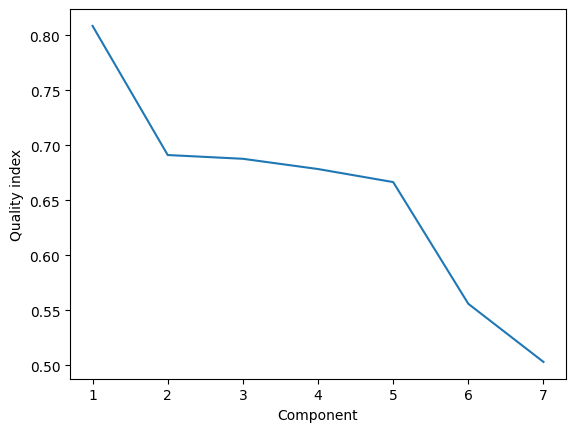

In [33]:
W_, scores, A, S = icasso.get_centrotype_unmixing(distance=0.5)
plt.figure()
plt.plot(range(1, len(scores)+1), scores)
plt.xticks(range(1, len(scores)+1),
           [str(idx) for idx in range(1, len(scores)+1)])
plt.xlabel('Component')
plt.ylabel('Quality index')
plt.show()

In [ ]:
comps = icasso._get_comps()

In [ ]:
print(comps.shape)

Try different component starting points and see at what distance they converge 

/home/ppxjf3/miniconda3/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/ppxjf3/miniconda3/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/ppxjf3/miniconda3/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/ppxjf3/miniconda3/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/ppxjf3/miniconda3/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: 

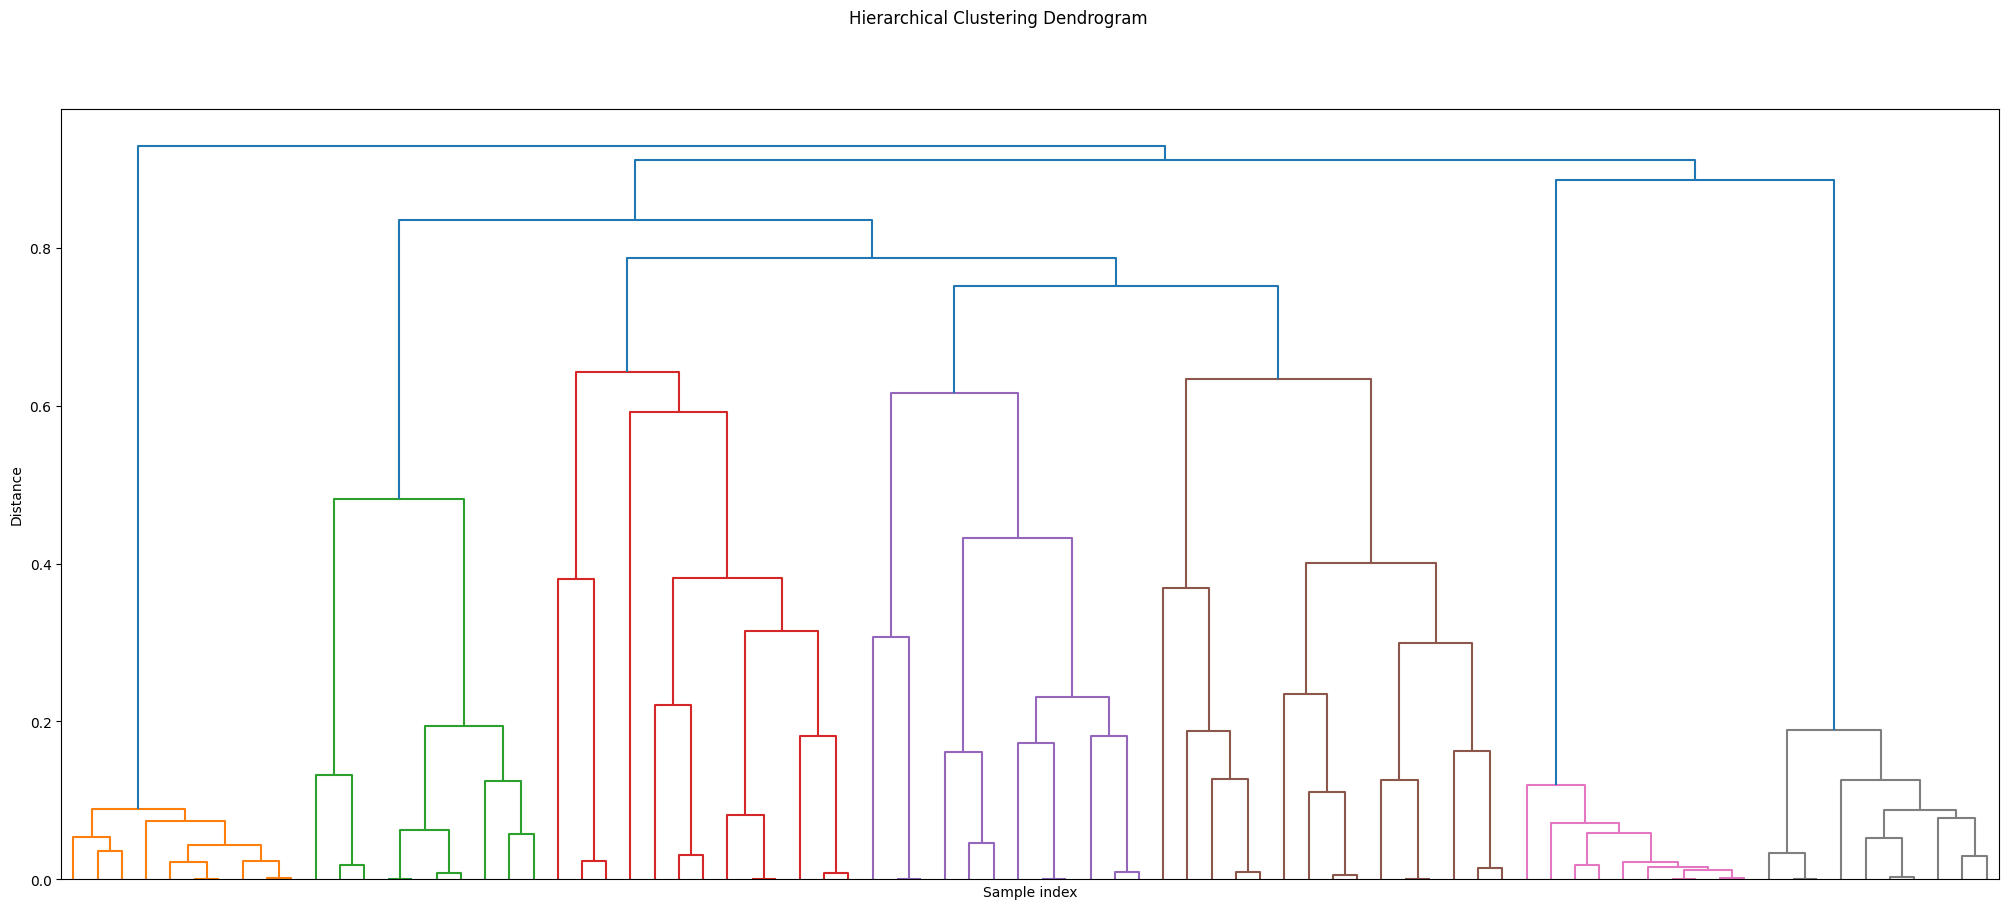

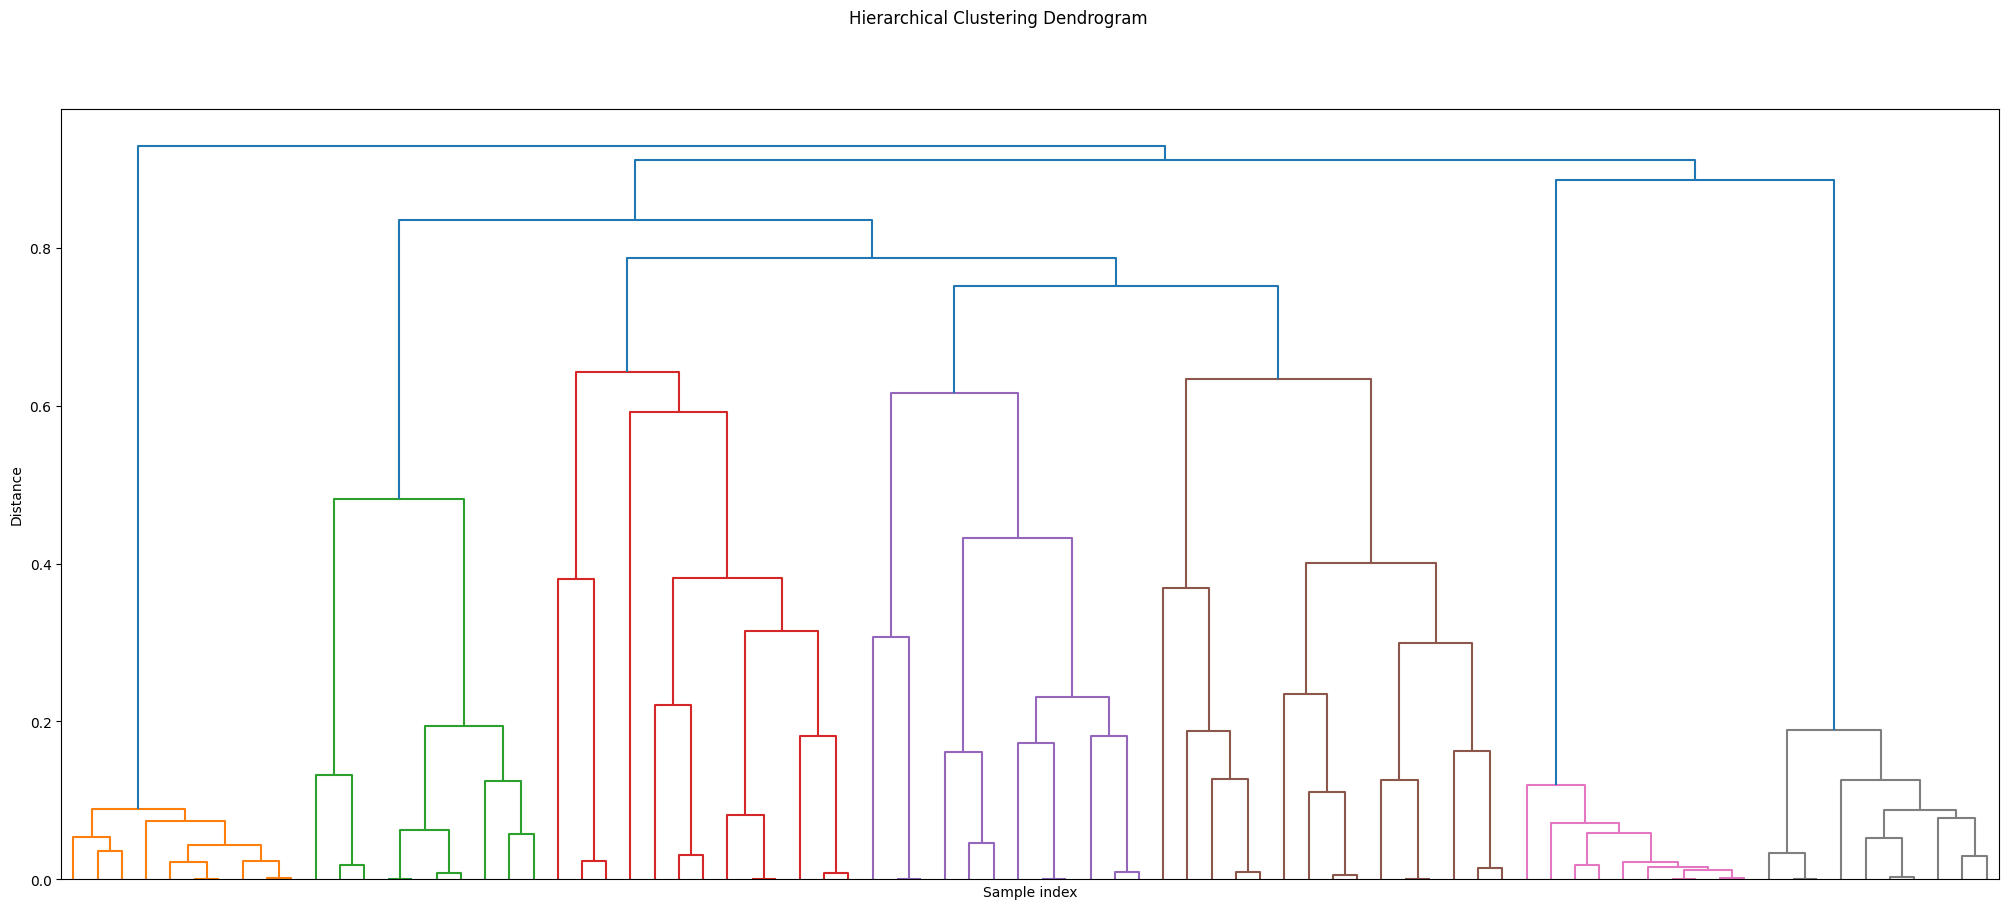

In [38]:
ica_params = {'n_components': 8} 
icasso8 = Icasso(FastICA, ica_params=ica_params, iterations=10, bootstrap=False,
                vary_init=True)


icasso8.fit(data=data_reshape, fit_params={}, random_state=random_state,
           bootstrap_fun=bootstrap_fun, unmixing_fun=unmixing_fun)

icasso8.plot_dendrogram()

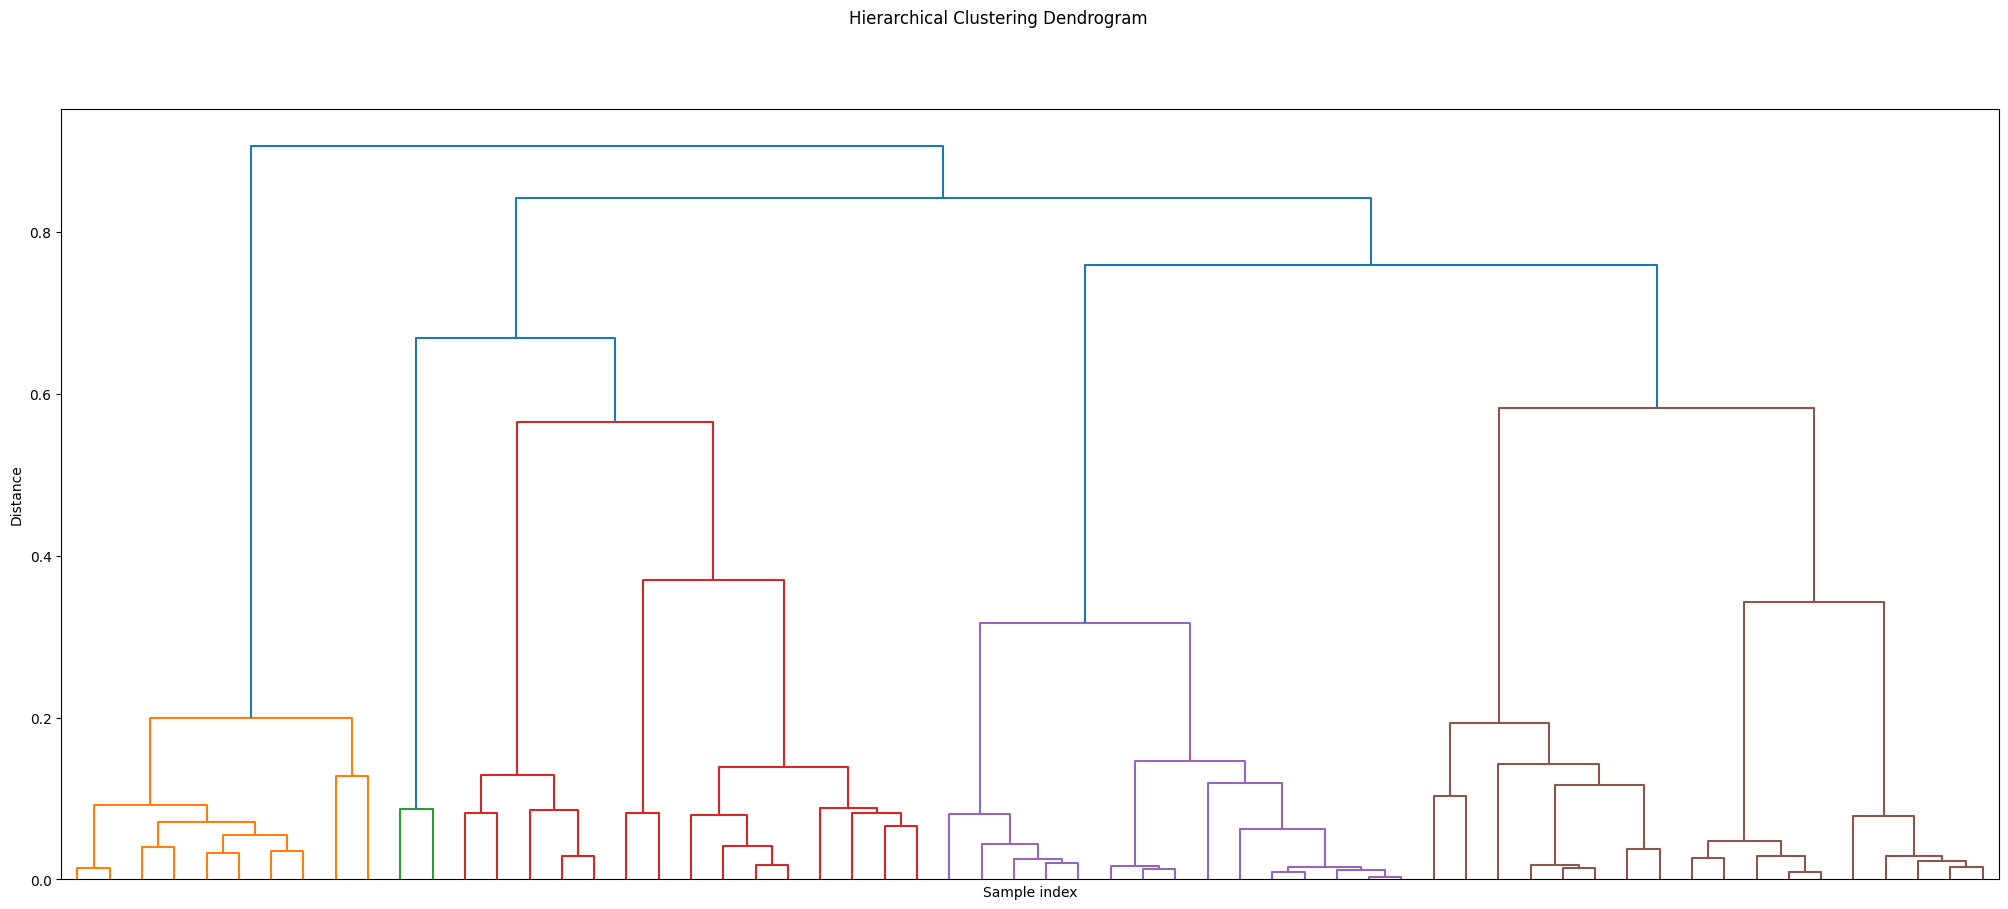

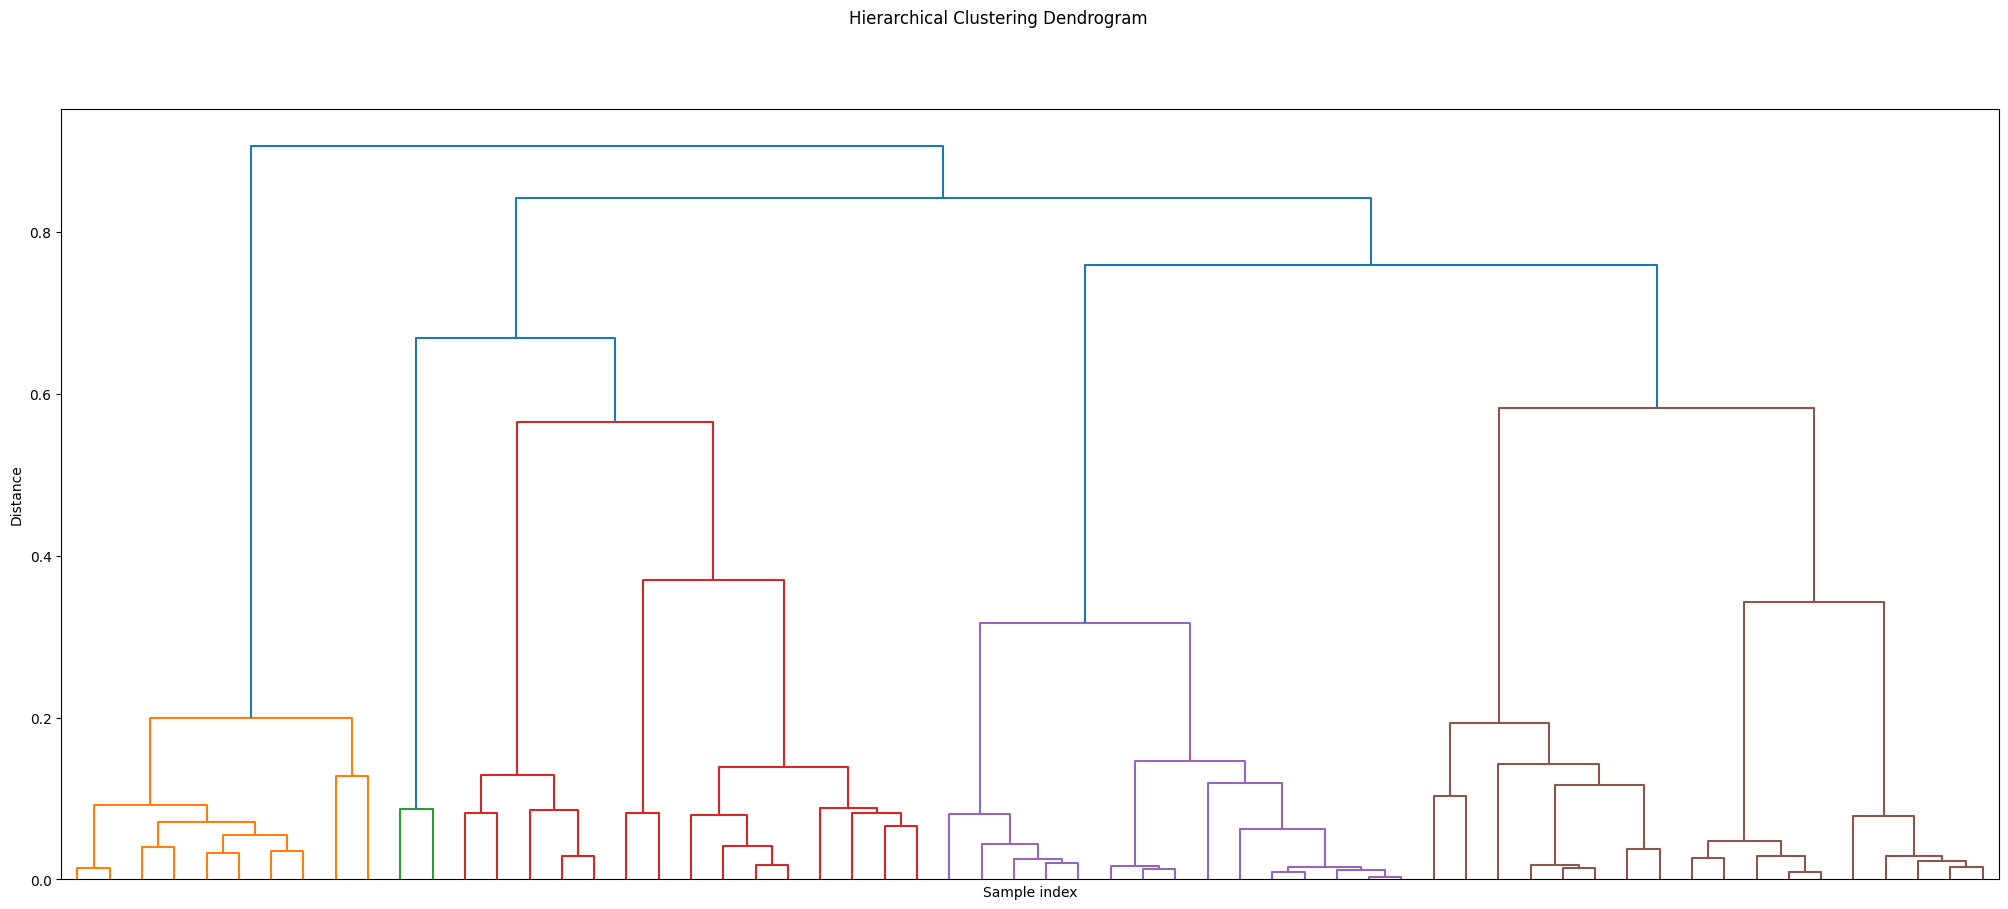

In [39]:
ica_params = {'n_components': 6} 
icasso6 = Icasso(FastICA, ica_params=ica_params, iterations=10, bootstrap=False,
                vary_init=True)


icasso6.fit(data=data_reshape, fit_params={}, random_state=random_state,
           bootstrap_fun=bootstrap_fun, unmixing_fun=unmixing_fun)

icasso6.plot_dendrogram()

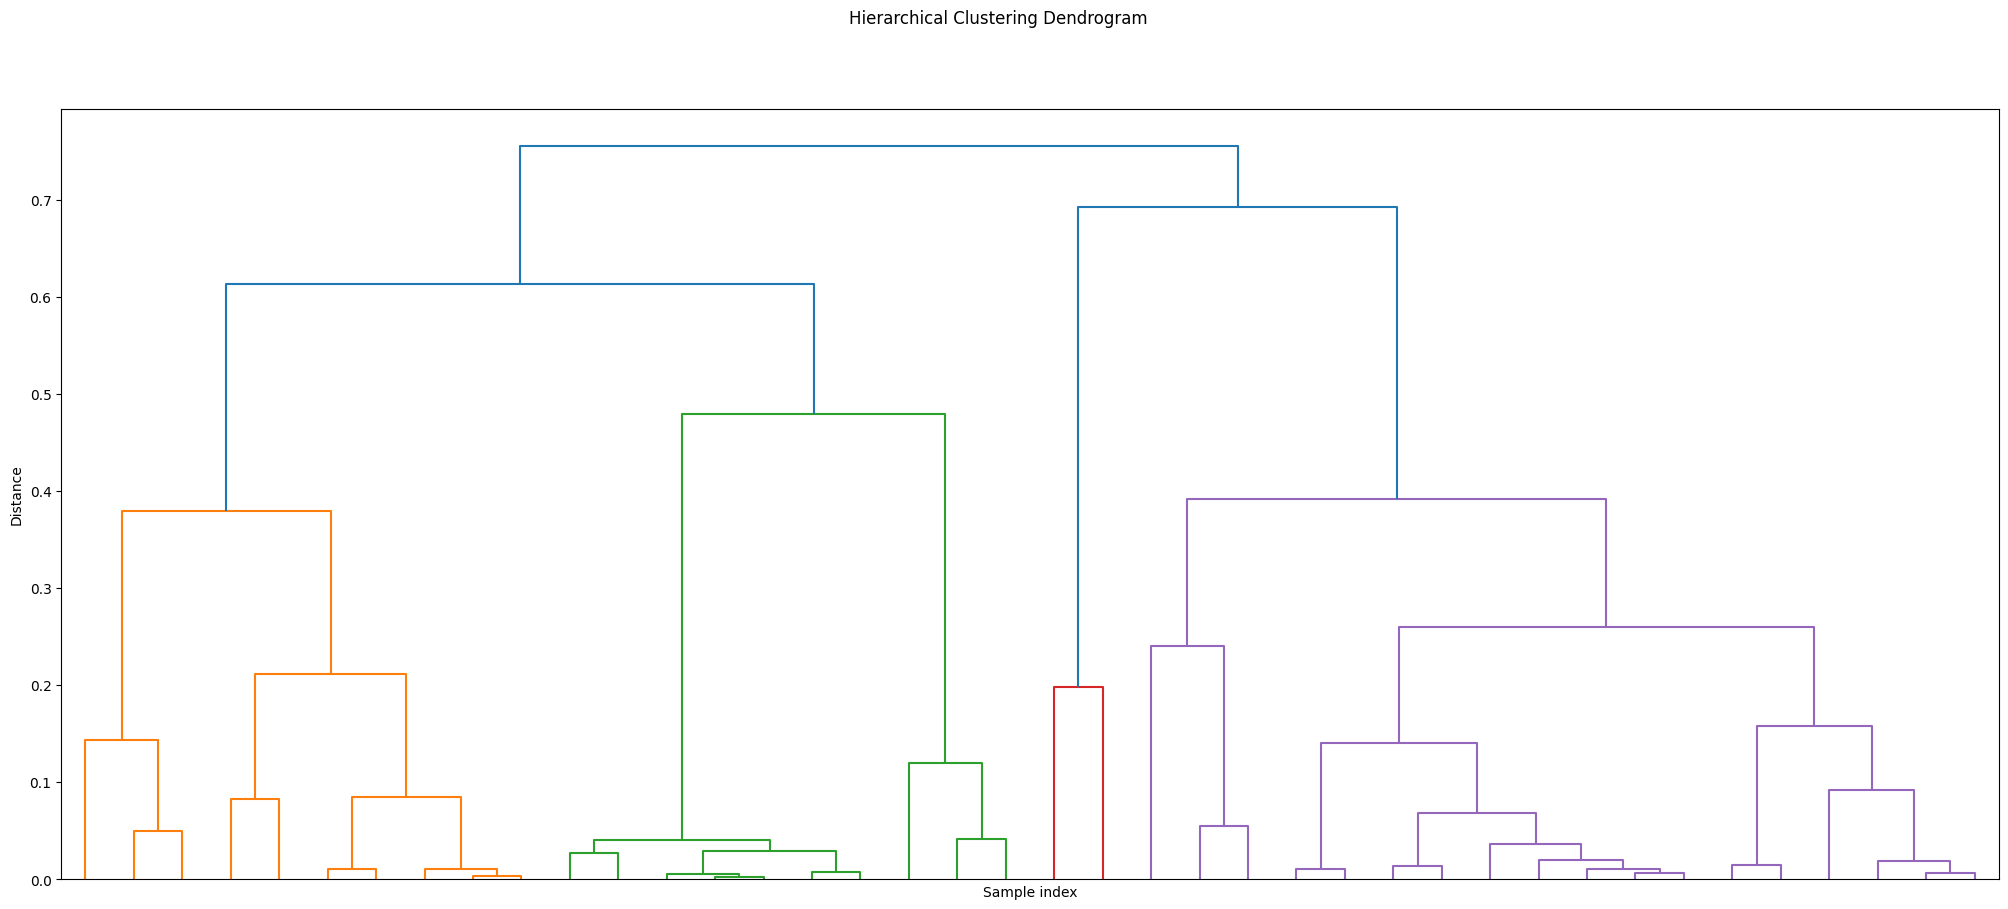

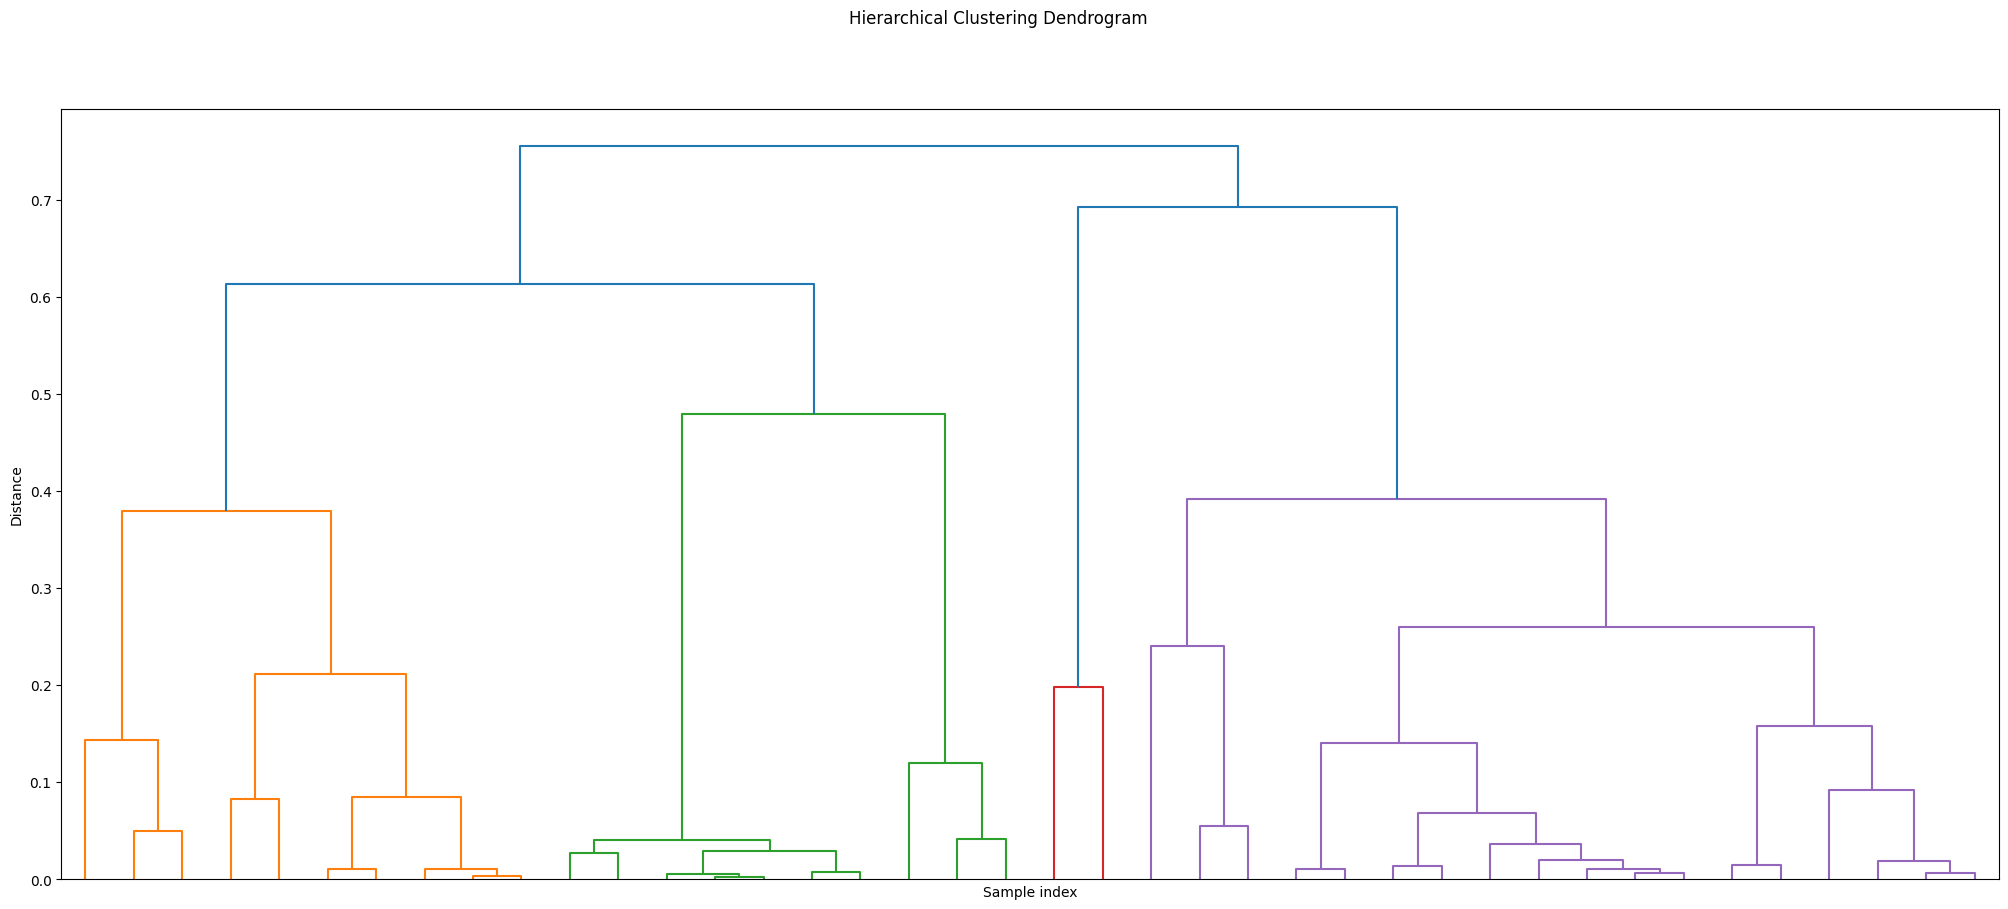

In [40]:
ica_params = {'n_components': 4} 
icasso4 = Icasso(FastICA, ica_params=ica_params, iterations=10, bootstrap=False,
                vary_init=True)


icasso4.fit(data=data_reshape, fit_params={}, random_state=random_state,
           bootstrap_fun=bootstrap_fun, unmixing_fun=unmixing_fun)

icasso4.plot_dendrogram()

In [51]:
dist = np.arange(0,0.8,0.1)
comp = np.empty([len(dist),3])
icassos = [icasso4, icasso6, icasso8]
model = np.empty([75,1024,1024,3])
for j in range(0,3):
    for i in range(0,len(dist)):
        #make model
        W_, scores, A, S = icassos[j].get_centrotype_unmixing(distance=dist[i])
        S_ = np.dot(W_, data_reshape.T) #ICs
        #temp = (np.matmul(A,S_))
        #model[:,:,:,j] = temp.reshape(75,1024,1024)
        comp[i,j] = len(S_)

In [52]:
print(comp[:,2])

[80. 38. 23. 19. 14. 11. 10.  7.]


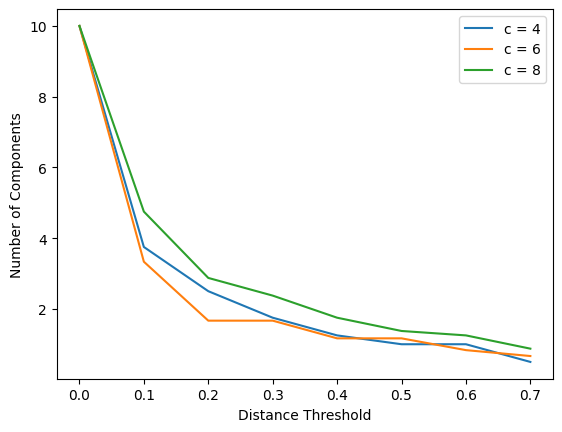

In [65]:
plt.plot(dist, comp[:,0]/4, label = 'c = 4') 
plt.plot(dist, comp[:,1]/6, label = 'c = 6')
plt.plot(dist, comp[:,2]/8, label = 'c = 8')
plt.ylabel('Number of Components')
plt.xlabel('Distance Threshold')
plt.legend()
plt.show()

In [59]:
#plot model and residuals for each 
dist1 = 0.5
model = np.empty([1024,1024,75,3])
resids = np.empty([1024,1024,75,3])
for j in range(0,3):
    #make model
    W_, scores, A, S = icassos[j].get_centrotype_unmixing(distance=dist1)
    S_ = np.dot(W_, data_reshape.T) #ICs
    temp = (np.matmul(A,S_))
    temp = temp.reshape(75,1024,1024)
    model[:,:,:,j]  = np.transpose(temp,(1,2,0))
    resids[:,:,:,j] = data - model[:,:,:,j]

In [68]:
# Get variance explained by singular values
W_, scores, A, S = icasso4.get_centrotype_unmixing(distance=0.5)
S_ = np.dot(W_, data_reshape.T)
explained_variance_ = (S_**2) / (data_reshape.shape[0] - 1)
total_var = explained_variance_.sum()
explained_variance_ratio_ = explained_variance_ / total_var
print(explained_variance_ratio_.shape)

"""plt.figure(figsize=(7, 7))
sns.scatterplot(
    x=np.arange(pca.n_components_), y=np.cumsum(pca.explained_variance_ratio_)
)
plt.xlabel("Principal Component")
plt.ylabel("Cumulative Explained Variance Ratio")

plt.show()"""

(4, 1048576)


'plt.figure(figsize=(7, 7))\nsns.scatterplot(\n    x=np.arange(pca.n_components_), y=np.cumsum(pca.explained_variance_ratio_)\n)\nplt.xlabel("Principal Component")\nplt.ylabel("Cumulative Explained Variance Ratio")\n\nplt.show()'

In [69]:
print(S_.shape)

(4, 1048576)


In [62]:
print(model[:,:,33,0])

[[-2.15641167e-02 -2.09759284e-02 -1.97797945e-02 ...  1.49815199e-02
   1.42467480e-02  1.35490027e-02]
 [-2.12594923e-02 -2.01440512e-02 -1.83629374e-02 ...  1.45928989e-02
   1.40141305e-02  1.34640922e-02]
 [-2.06023449e-02 -1.90585856e-02 -1.78084834e-02 ...  1.42257286e-02
   1.35134783e-02  1.31849793e-02]
 ...
 [-5.37324721e-03 -6.33763571e-03 -7.02664815e-03 ...  1.07010588e-04
  -7.93550662e-05 -5.80833163e-05]
 [-4.73820121e-03 -5.50822910e-03 -6.26096219e-03 ... -2.18996299e-05
  -1.59932106e-04  6.78369732e-05]
 [-4.21173042e-03 -4.66075897e-03 -5.47944868e-03 ...  9.49195730e-06
  -5.20567153e-05  5.97082070e-04]]


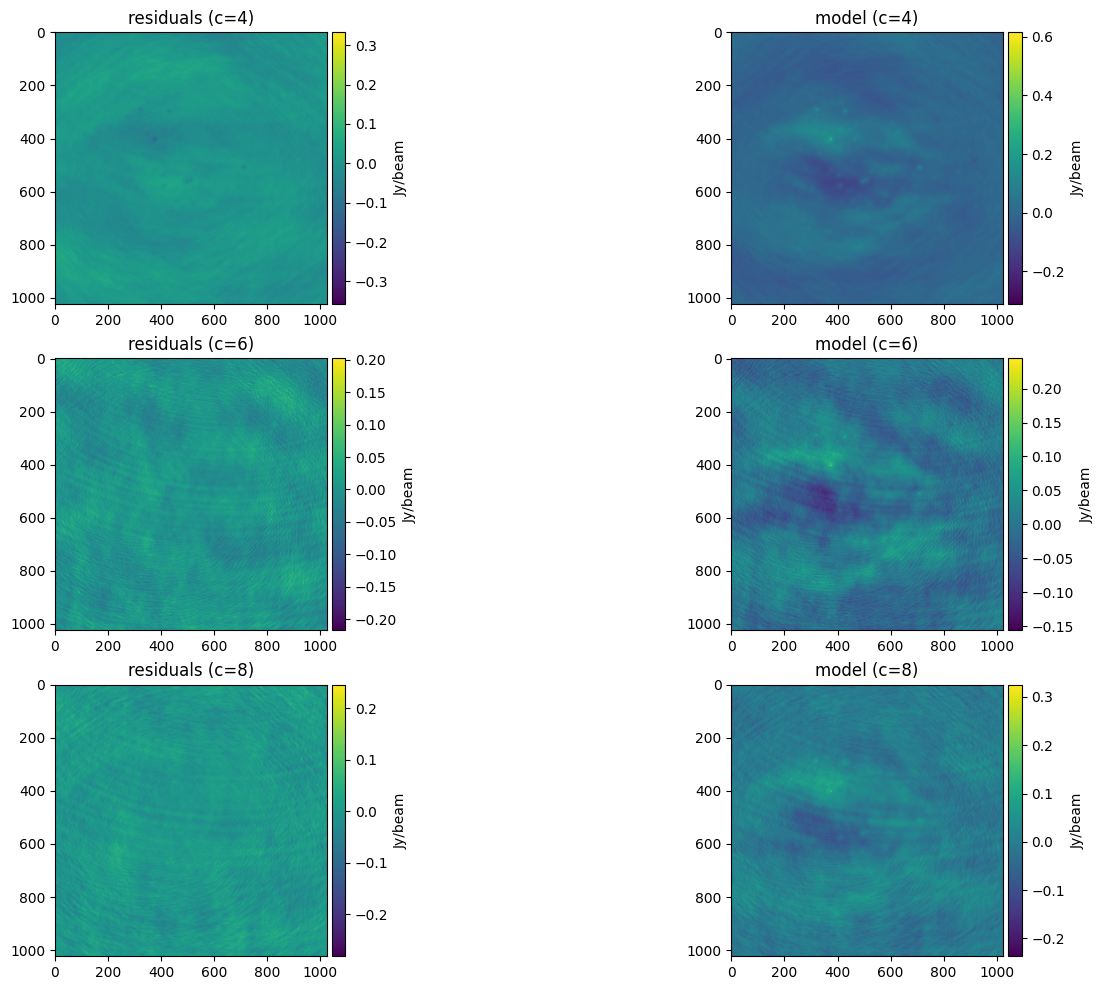

In [93]:
fig = plt.figure(figsize=(16, 12))
ax1 = fig.add_subplot(321)
im1 = ax1.imshow(model[:,:,33,0])
ax1.set_title('residuals (c=4)')
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical', label='Jy/beam')

ax2 = fig.add_subplot(322)
im2 = ax2.imshow(resids[:,:,33,0])
ax2.set_title('model (c=4)')
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical', label='Jy/beam')

ax3 = fig.add_subplot(323)
im3 = ax3.imshow(model[:,:,33,1])
ax3.set_title('residuals (c=6)')
divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im3, cax=cax, orientation='vertical', label='Jy/beam')

ax4 = fig.add_subplot(324)
im4 = ax4.imshow(resids[:,:,33,1])
ax4.set_title('model (c=6)')
divider = make_axes_locatable(ax4)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im4, cax=cax, orientation='vertical', label='Jy/beam')

ax5 = fig.add_subplot(325)
im5 = ax5.imshow(model[:,:,33,2])
ax5.set_title('residuals (c=8)')
divider = make_axes_locatable(ax5)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im5, cax=cax, orientation='vertical', label='Jy/beam')

ax6 = fig.add_subplot(326)
im6 = ax6.imshow(resids[:,:,33,2])
ax6.set_title('model (c=8)')
divider = make_axes_locatable(ax6)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im6, cax=cax, orientation='vertical', label='Jy/beam')

In [ ]:
#compare above to truth 


In [ ]:
plt.hexbin(comps, corel,  gridsize=50, cmap='viridis')

In [ ]:
#make model
model3 = (np.matmul(A3,(s3.reshape(1024*1024,3)).T)).reshape((shape[0],shape[1],shape[2]))
model4 = (np.matmul(A4,(s4.reshape(1024*1024,4)).T)).reshape((shape[0],shape[1],shape[2]))
    
#get resids
resids3 = data - model3 #residuals 
resids4 = data - model4 #residuals 

In [ ]:
plt.imshow(resids3[:,:,33])

In [18]:
plt.imshow(model[:,:,33])

NameError: name 'model' is not defined

In [ ]:
plt.imshow(model4[:,:,33])